Let's dig deeper into surface codes. We will take the example of a distance=4 surface code and apply a few decoding tests.

First, import a few common dependencies:

In [1]:
from matplotlib import pyplot as plt
from jupyter_plotter import plot_jupyter_figure
import pymatching

from circuit_generators import get_builtin_circuit, get_custom_circuit
from sampling_functions import create_task_sinter, generate_samples_sinter, get_variable_from_sample_sinter, plot_error_rate_sinter

# Also define the number of worker nodes here
n_worker_nodes = 8

Create tasks for the distance=4 surface code (built-in `rotated_memory_z` code):

In [2]:
n_samples = 1000000
decoders = ['pymatching']
distances = sorted([4])
rounds = sorted([1, 2, 4, 8, 12])
noise_levels = sorted([0.001, 0.0015, 0.003, 0.005, 0.01, 0.02])

tasks = [
  create_task_sinter(
    fcn_circuit_generator = get_builtin_circuit,
    args_circuit_generator = {
      "builtin_name": "surface_code:rotated_memory_z", "distance": d, "rounds": r,
      "after_reset_flip_probability": noise,
      "after_clifford_depolarization": noise,
      "before_round_data_depolarization": noise,
      "before_measure_flip_probability": noise,
      },
    json_metadata = {'distance': d, 'noise': noise, 'rounds': r}
  )
  for d in distances
  for r in rounds
  for noise in noise_levels
]

results = generate_samples_sinter(
  num_workers = n_worker_nodes,
  tasks = tasks,
  decoders = decoders,
  num_samples = n_samples,
)

Plot the logical error rates per shot and per round for the different rounds per distance:

c:\Users\ulasc\OneDrive\USARICA\Documents\Miscellaneous\Projects\FNAL Quantum\Decoding tests\FNAL-QCDecodingTests\jupyter_plotter.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


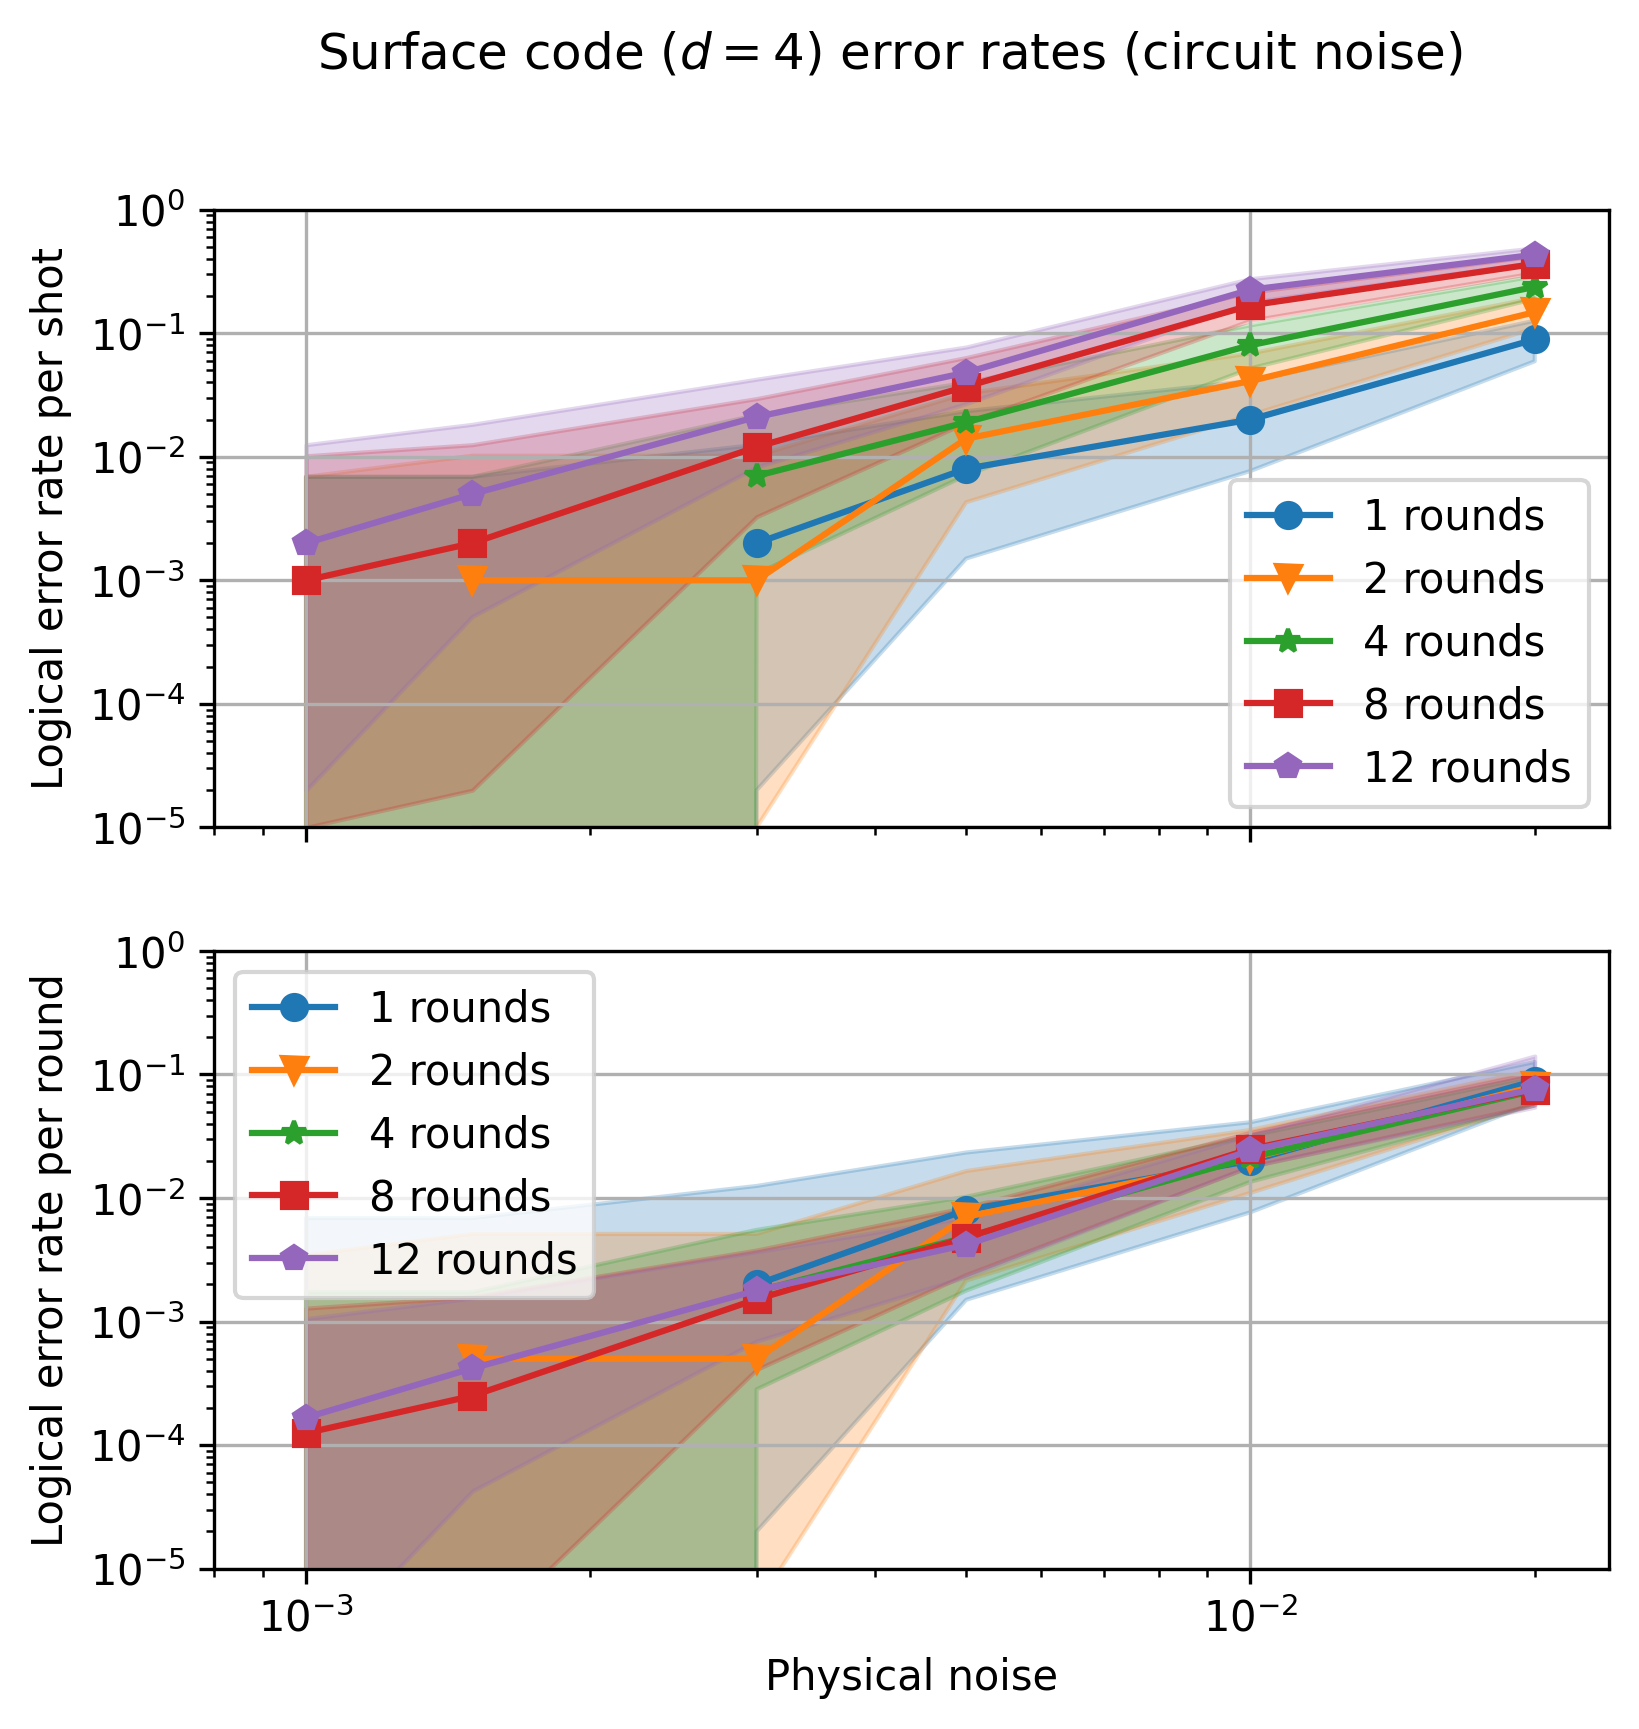

In [3]:
fig, (axl, axr) = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
plot_label = "Surface code ($d=4$) error rates (circuit noise)"
group_labels = dict()
for r in rounds:
  group_labels[r] = f"{r} rounds"
plot_error_rate_sinter(
  axl, results, "noise", "Physical noise", "Logical error rate per shot",
  group_title="rounds", group_labels=group_labels,
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-5, 1.)
)
plot_error_rate_sinter(
  axr, results, "noise", "Physical noise", "Logical error rate per round",
  group_title="rounds", group_labels=group_labels,
  x_range=(noise_levels[0]*0.8, noise_levels[-1]*1.2), y_range=(1e-5, 1.),
  failure_units_per_shot_func = lambda st, tt="rounds": get_variable_from_sample_sinter(st, tt)
)
axl.label_outer()
axr.label_outer()
fig.suptitle(plot_label)
fig.set_dpi(300)
plot_jupyter_figure(fig)

Error rate per round between 1-round measurements vs. 12 only seem to be different by ~30%. For now, pick simple 1-round measurements.

In [4]:
test_circuits = [ tasks[i].circuit for i in range(len(noise_levels)) ] # No need to remake the circuits, just pick those from the innermost for-loop

Let's try a different decoder algorithm, [BP+OSD using stim](https://github.com/oscarhiggott/stimbposd).

Note 1: The stim implementation is based on [ldpc](https://github.com/quantumgizmos/ldpc), which asks [this paper](https://doi.org/10.1103/PhysRevResearch.2.043423) to be cited.

Note 2: The speed of the `bposd` decoder run is slow (x <1/100) compared to pyMatching (24 minutes and still counting vs 9 s for 1000 shots).

Note 3 (after 30 minutes): Let's leave this for a longer day to run on its own.

In [7]:
"""
from stimbposd import BPOSD, SinterDecoder_BPOSD
from stimbposd import sinter_decoders as sinter_decoders_bposd

# Refresh the tasks just in case task objects act funky
# Keep the circuits and corresponding noise levels
tasks = [
  create_task_sinter(
    fcn_circuit_generator = get_custom_circuit,
    args_circuit_generator = { "circuit": test_circuits[i] },
    json_metadata = {'noise': noise_levels[i]}
  )
  for i in range(len(noise_levels))
]

decoders = ['bposd']
results_with_bposd = generate_samples_sinter(
  num_workers = 15,
  tasks = tasks,
  decoders = decoders,
  num_samples = n_samples,
  custom_decoders = sinter_decoders_bposd
)
"""